# BigMart Sales Prediction- Regression Project

In the following regression project, a dataset of more than 14,000 BigMart sales records has been analyzed and modelled, applying diverse regression models to forecast product sales at individual stores.

We will explore the problem in following stages:

* Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
* Data Cleaning – imputing missing values in the data and checking for outliers
* Feature Engineering – modifying existing variables and creating new ones for analysis
* Model Building – making predictive models on the data

This dataset represents 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

# Data Exploration & Feature Engineering

# 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [108]:
#Read files:
train = pd.read_csv("data/bigmart-sales-prediction/train.csv")
test = pd.read_csv("data/bigmart-sales-prediction/test.csv")

In [109]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [110]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [111]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Its generally a good idea to combine both train and test data sets into one, perform feature engineering and then divide them later again. This saves the trouble of performing the same steps twice on test and train. Lets combine them into a dataframe ‘data’ with a ‘source’ column specifying where each observation belongs.

In [112]:
#Combine test and train into one file
train['source']='train' #Adds a columns to train dataset with title 'source' and elements 'train'
test['source']='test' #Adds a columns to test dataset with title 'source' and elements 'test'

data = pd.concat([train, test],ignore_index=True) #Concatenate pandas objects along a particular axis, default axis=0.
#ignore_index: if False: the index of the test set starts from 0. If True, the index of the test set starts from 8523.

train.shape, test.shape, data.shape

((8523, 13), (5681, 12), (14204, 13))

In [113]:
#Check missing values:
data.apply(lambda x: x.isnull().sum()) # or data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [114]:
#Numerical data summary:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Some observations:

1. Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.

2. Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.

In [115]:
#Number of unique values in each column (unique function imagines nulls as a unique item)
data.apply(lambda x: len(x.unique())) 

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

In [116]:
data.Outlet_Size.unique(), len(data.Outlet_Size.unique())

(array(['Medium', nan, 'High', 'Small'], dtype=object), 4)

In [117]:
data.nunique() #nunique function only counts the cells with a value (ignores nulls)

Item_Identifier               1559
Item_Weight                    415
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      3
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3493
source                           2
dtype: int64

In [118]:
data.Outlet_Size.nunique()

3

In [119]:
data.agg(['size', 'count', 'nunique'])
#size: Counts total values including null values
#count: Counts only non-null values
#nunique: Count distinct non-null values

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
size,14204,14204,14204,14204,14204,14204,14204,14204,14204,14204,14204,14204,14204
count,14204,11765,14204,14204,14204,14204,14204,14204,10188,14204,14204,8523,14204
nunique,1559,415,5,13006,16,8052,10,9,3,3,4,3493,2


This tells us that there are 1559 products and 10 outlets/stores. Another thing that should catch attention is that Item_Type has 16 unique values. 

Let’s explore further using the frequency of different categories in each nominal (categorical) variable. I’ll exclude the ID and source variables for obvious reasons.

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

In [122]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: count, dtype: int64

Frequency of Categories for varible Item_Type
Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: count, dtype: int64

Frequency of Categories for varible Outlet_Size
Outlet_Size
Medium    4655
Small     3980
High      1553
Name: count, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name

The output gives us following observations:

1. Item_Fat_Content: Some of ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’. Also, some of ‘Regular’ are mentioned as ‘regular’.
2. Item_Type: Not all categories have substantial numbers. It looks like combining them can give better results.
3. Outlet_Type: Supermarket Type2 and Type3 can be combined. But we should check if that’s a good idea before doing it.

# 2. Data Cleaning

This step typically involves imputing missing values and treating outliers. Though outlier removal is very important in regression techniques, advanced tree based algorithms are impervious to outliers. We’ll focus on the imputation step here, which is a very important step.

### Imputing Missing Values
We found two variables with missing values – Item_Weight and Outlet_Size. Lets impute the former by the average weight of the particular item. This can be done as:

#### impute numeric columns

In [125]:
item_avg_weight = data.pivot_table(columns='Item_Identifier', values='Item_Weight', aggfunc='mean')
item_avg_weight
# or: item_avg_weight = data.groupby('Item_Identifier')[['Item_Weight']].mean().T

Item_Identifier,DRA12,DRA24,DRA59,DRB01,DRB13,DRB24,DRB25,DRB48,DRC01,DRC12,...,NCZ05,NCZ06,NCZ17,NCZ18,NCZ29,NCZ30,NCZ41,NCZ42,NCZ53,NCZ54
Item_Weight,11.6,19.35,8.27,7.39,6.115,8.785,12.3,16.75,5.92,17.85,...,8.485,19.6,12.15,7.825,15.0,6.59,19.85,10.5,9.6,14.65


In [126]:
miss_bool = data['Item_Weight'].isnull()

In [127]:
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight[x])

In [128]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

#### impute object columns

In [129]:
from scipy.stats import mode
outlet_size_mode = data.pivot_table(columns='Outlet_Type', values='Outlet_Size', aggfunc=(lambda x: x.mode()))
outlet_size_mode
# or: outlet_size_mode = data.groupby('Outlet_Type')[['Outlet_Size']].agg(lambda x: x.mode()).T
# or: outlet_size_mode = data.groupby('Outlet_Type')[['Outlet_Size']].apply(lambda x: x.mode()).T

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [130]:
miss_bool = data['Outlet_Size'].isnull() 

In [131]:
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [132]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

# 3. Feature Engineering:

### Step1: Consider combining categories in Outlet_Type

During exploration, we decided to consider combining the Supermarket Type2 and Type3 variables. But is that a good idea? A quick way to check that could be to analyze the mean sales by type of store. If they have similar sales, then keeping them separate won’t help much.

In [259]:
#Check the mean sales by outlet type:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type') 

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,921.629500
Supermarket Type1,2107.474778
Supermarket Type2,1915.083692
Supermarket Type3,2933.668118


This shows significant difference between them and we’ll leave them as it is. Note that this is just one way of doing this, you can perform some other analysis in different situations and also do the same for other features.

### Step2: Modify Item_Visibility

We noticed that the minimum value here is 0, which makes no practical sense. Lets consider it like missing information and impute it with mean visibility of that product (based on Item_Identifier).

In [263]:
data.pivot_table(values='Item_Visibility',index='Item_Identifier') 

,Item_Visibility
Item_Identifier,
DRA12,0.034938
DRA24,0.045646
DRA59,0.133384
DRB01,0.079736
DRB13,0.006799
...,...
NCZ30,0.027302
NCZ41,0.056396
NCZ42,0.011015


In [264]:
data.Item_Visibility = data.Item_Visibility.mask(data.Item_Visibility==0)  #Converts zeros to nan in that column

In [265]:
data.Item_Visibility.isnull().sum()

879

In [266]:
#Replacing nans of a column with mean of items based on Item_Identifier
data['Item_Visibility'] = data['Item_Visibility'].fillna(data.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))

In [267]:
data.Item_Visibility.isnull().sum()

0

In [268]:
data.describe() #Now the min of Item_Visibility isn't zero

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000
mean,12.759739,0.070458,141.004977,1997.830681,2026.522094
std,4.234851,0.050086,62.086938,8.371664,1335.388924
min,4.555000,0.003575,31.290000,1985.000000,33.290000
25%,9.300000,0.031381,94.012000,1987.000000,1468.089000
50%,12.600000,0.058064,142.247000,1999.000000,1794.331000
75%,16.000000,0.098042,185.855600,2004.000000,2163.184200
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Step3: Adding a Column Called Item_Visibility_MeanRatio

In step 1 we hypothesized that products with higher visibility are likely to sell more. But along with comparing products on absolute terms, we should look at the visibility of the product in that particular store as compared to the mean visibility of that product across all stores. This will give some idea about how much importance was given to that product in a store as compared to other stores.

For this purpose we divide the visibility of each item by the average visibility of that item based on Item_Identifier.

In [271]:
#Creating a column with nans
data['Mean_Item_Vis']=np.nan

In [272]:
#Fill nans with mean of Item_Visibility grouped by Item_Identifier
data['Mean_Item_Vis'] = data['Mean_Item_Vis'].fillna(data.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))

In [273]:
data['Mean_Item_Vis'].describe()

count    14204.000000
mean         0.070458
std          0.046967
min          0.003895
25%          0.032617
50%          0.059044
75%          0.099149
max          0.217421
Name: Mean_Item_Vis, dtype: float64

In [274]:
#creating a new column: visibility of each item divided by the average visibility of that item based on Item_Identifier
data['Item_Visibility_MeanRatio'] = data['Item_Visibility'] / data['Mean_Item_Vis']

In [275]:
data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.000000
std          0.200592
min          0.803455
25%          0.901974
50%          0.925261
75%          1.000000
max          1.614811
Name: Item_Visibility_MeanRatio, dtype: float64

In [276]:
#Mean_Item_Vis column is no longer needed.
data = data.drop('Mean_Item_Vis',axis=1)

Thus the new variable has been successfully created.

### Step 4: Remove the skewness if Item_Visibility

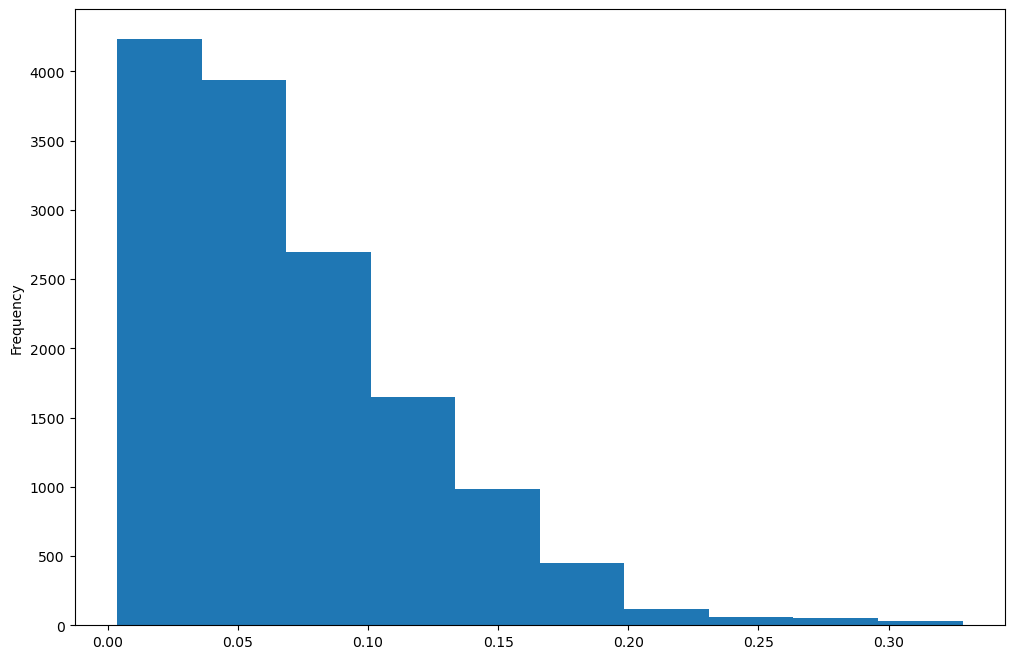

In [278]:
data['Item_Visibility'].plot.hist();

In [280]:
data.Item_Visibility = np.log(data.Item_Visibility)

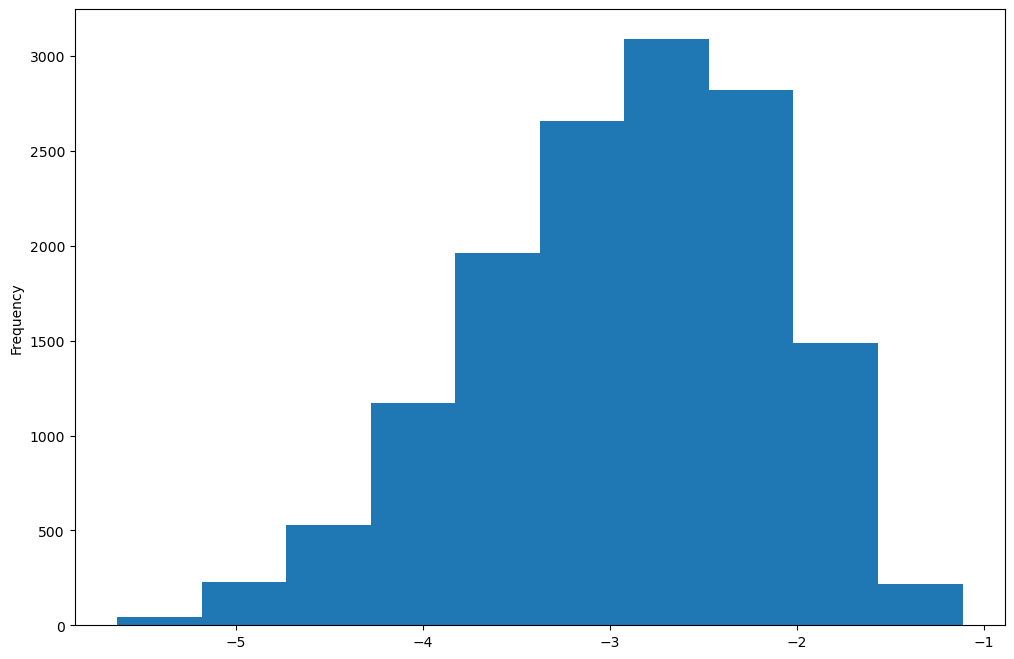

In [282]:
data['Item_Visibility'].plot.hist();

### Step 6: Create a broad category of Type of Item

Earlier we saw that the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. But there’s a catch here. If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So I’ve used the Item_Identifier variable to create a new column:

In [283]:
data['Item_Type_Combined'] = data['Item_Identifier'] #Adding a new column
data["Item_Type_Combined"] = data["Item_Type_Combined"].str[:2] #Keeps only the first two letters
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Visibility_MeanRatio,Item_Type_Combined
0,FDA15,9.30,Low Fat,-4.132215,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.931078,FD
1,DRC01,5.92,Regular,-3.948780,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.933420,DR
2,FDN15,17.50,Low Fat,-4.088756,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.864062,FD
3,FDX07,19.20,Regular,-3.775315,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train,1.000000,FD
4,NCD19,8.93,Low Fat,-4.221968,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,1.000000,NC


In [285]:
#This replaces FD with Food, ... The important point about .map is that the items which are not selected will be replaced
#with nan. Suppose we had Fish in Item_Type_Combined column. After running this cell, Fish would have been replaced by nan.
#Conversely, .replace doesn't put nan for the items which are not selected.
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Visibility_MeanRatio,Item_Type_Combined
0,FDA15,9.30,Low Fat,-4.132215,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,0.931078,Food
1,DRC01,5.92,Regular,-3.948780,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.933420,Drinks
2,FDN15,17.50,Low Fat,-4.088756,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,0.864062,Food
3,FDX07,19.20,Regular,-3.775315,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train,1.000000,Food
4,NCD19,8.93,Low Fat,-4.221968,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,1.000000,Non-Consumable


In [286]:
data['Item_Type_Combined'].value_counts() #We reduced the item type from 16 to 3

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [287]:
#Item_Type column is no longer needed.
data.drop(['Item_Type'],axis=1, inplace=True)

Another idea could be to combine categories based on sales. The ones with high average sales could be combined together.

### Step 5: Determine the years of operation of a store

We wanted to make a new column depicting the years of operation of a store. This can be done as:

In [288]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

This shows stores are 4-28 years old.

In [289]:
#Outlet_Establishment_Year column is no longer needed.
data.drop(['Outlet_Establishment_Year'],axis=1, inplace=True)

### Step 7: Modify categories of Item_Fat_Content

We found typos and difference in representation in categories of Item_Fat_Content variable. This can be corrected as:

In [290]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


Now it makes more sense. But hang on, in step 4 we saw there were some non-consumables as well and a fat-content should not be specified for them. So we can also create a separate category for such kind of observations.

In [291]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

### Step 8: Numerical and One-Hot Coding of Categorical variables

Since scikit-learn accepts only numerical variables, I converted all categories of nominal variables (object) into numeric types. Also, I wanted Outlet_Identifier as a variable as well. So I created a new variable ‘Outlet’ same as Outlet_Identifier and coded that. Outlet_Identifier should remain as it is, because it will be required in the submission file.

Lets start with coding all categorical variables as numeric using ‘LabelEncoder’ from sklearn’s preprocessing module.

In [292]:
data['Outlet'] = data['Outlet_Identifier']

In [293]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
Item_Visibility_MeanRatio    float64
Item_Type_Combined            object
Outlet_Years                   int64
Outlet                        object
dtype: object

In [294]:
# Turn the categories into numbers
# By this method we won't have column names (see dataframe below)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Converting these columns into one hot encoded variables
categorical_features = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Type_Combined','Outlet'] 
one_hot = OneHotEncoder()
transformer = ColumnTransformer([('one_hot', one_hot, categorical_features)], remainder='passthrough')
transformed_data = transformer.fit_transform(data)

In [295]:
transformed_data

array([[1.0, 0.0, 0.0, ..., 'train', 0.9310779543761085, 14],
       [0.0, 0.0, 1.0, ..., 'train', 0.9334195208758377, 4],
       [1.0, 0.0, 0.0, ..., 'train', 0.8640618785143601, 14],
       ...,
       [0.0, 1.0, 0.0, ..., 'test', 0.9039680116182265, 11],
       [0.0, 0.0, 1.0, ..., 'test', 1.0, 6],
       [0.0, 0.0, 1.0, ..., 'test', 0.915269633466472, 11]], dtype=object)

In [296]:
pd.DataFrame(transformed_data).head().T #3 columns are still object: Item_Identifier, Outlet_Identifier, source

,0,1,2,3,4
0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0
7,1.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,1.0,1.0


One-Hot-Coding refers to creating dummy variables, one for each category of a categorical variable. For example, the Item_Fat_Content has 3 categories – ‘Low Fat’, ‘Regular’ and ‘Non-Edible’. One hot coding will remove this variable and generate 3 new variables. Each will have binary numbers – 0 (if the category is not present) and 1 (if category is present). This can be done using ‘get_dummies’ function of Pandas.

In [297]:
dummies = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Type_Combined','Outlet']) 

In [298]:
dummies.head().T

,0,1,2,3,4
Item_Identifier,FDA15,DRC01,FDN15,FDX07,NCD19
Item_Weight,9.3,5.92,17.5,19.2,8.93
Item_Visibility,-4.132215,-3.94878,-4.088756,-3.775315,-4.221968
Item_MRP,249.8092,48.2692,141.618,182.095,53.8614
Outlet_Identifier,OUT049,OUT018,OUT049,OUT010,OUT013
Item_Outlet_Sales,3735.138,443.4228,2097.27,732.38,994.7052
source,train,train,train,train,train
Item_Visibility_MeanRatio,0.931078,0.93342,0.864062,1.0,1.0
Outlet_Years,14,4,14,15,26
Item_Fat_Content_Low Fat,1,0,1,0,0


In [299]:
dummies.dtypes

Item_Identifier                       object
Item_Weight                          float64
Item_Visibility                      float64
Item_MRP                             float64
Outlet_Identifier                     object
Item_Outlet_Sales                    float64
source                                object
Item_Visibility_MeanRatio            float64
Outlet_Years                           int64
Item_Fat_Content_Low Fat               uint8
Item_Fat_Content_Non-Edible            uint8
Item_Fat_Content_Regular               uint8
Outlet_Size_High                       uint8
Outlet_Size_Medium                     uint8
Outlet_Size_Small                      uint8
Outlet_Location_Type_Tier 1            uint8
Outlet_Location_Type_Tier 2            uint8
Outlet_Location_Type_Tier 3            uint8
Outlet_Type_Grocery Store              uint8
Outlet_Type_Supermarket Type1          uint8
Outlet_Type_Supermarket Type2          uint8
Outlet_Type_Supermarket Type3          uint8
Item_Type_

### Step9: Exporting Data

Final step is to convert data back into train and test data sets. Its generally a good idea to export both of these as modified data sets so that they can be re-used for multiple sessions. This can be achieved using following code:

In [304]:
#Divide into train and test:
train = dummies.loc[dummies['source']=="train"]
test = dummies.loc[dummies['source']=="test"]

#Drop unnecessary columns:
train.drop(['source'],axis=1,inplace=True)
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("data/bigmart-sales-prediction/train_modified.csv",index=False)
test.to_csv("data/bigmart-sales-prediction/test_modified.csv",index=False)

C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\1369196927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['source'],axis=1,inplace=True)
C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\1369196927.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)


# 4. Modelling

Now that we have the data ready, its time to start making predictive models. I will take you through 6 models including KNN, linear regression, ridge regression, decision tree, random forest, and upport Vector Regressor (SVR).

In [305]:
train = pd.read_csv("data/bigmart-sales-prediction/train_modified.csv")
test = pd.read_csv("data/bigmart-sales-prediction/test_modified.csv")

In [306]:
print(train.shape), print(test.shape)
train.dtypes

(8523, 34)
(5681, 33)


Item_Identifier                       object
Item_Weight                          float64
Item_Visibility                      float64
Item_MRP                             float64
Outlet_Identifier                     object
Item_Outlet_Sales                    float64
Item_Visibility_MeanRatio            float64
Outlet_Years                           int64
Item_Fat_Content_Low Fat               int64
Item_Fat_Content_Non-Edible            int64
Item_Fat_Content_Regular               int64
Outlet_Size_High                       int64
Outlet_Size_Medium                     int64
Outlet_Size_Small                      int64
Outlet_Location_Type_Tier 1            int64
Outlet_Location_Type_Tier 2            int64
Outlet_Location_Type_Tier 3            int64
Outlet_Type_Grocery Store              int64
Outlet_Type_Supermarket Type1          int64
Outlet_Type_Supermarket Type2          int64
Outlet_Type_Supermarket Type3          int64
Item_Type_Combined_Drinks              int64
Item_Type_

## Baseline model:

Lets start by making a baseline model. Baseline model is the one which requires no predictive model and its like an informed guess. For instance, in this case lets predict the sales as the overall average sales. This can be done as:

In [307]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

In [308]:
#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1

,Item_Identifier,Outlet_Identifier
0,FDW58,OUT049
1,FDW14,OUT017
2,NCN55,OUT010
3,FDQ58,OUT017
4,FDY38,OUT027
...,...,...
5676,FDB58,OUT046
5677,FDD47,OUT018
5678,NCO17,OUT045
5679,FDJ26,OUT017


In [309]:
base1['Item_Outlet_Sales'] = mean_sales
base1

C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\1312995710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base1['Item_Outlet_Sales'] = mean_sales


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,2181.288914
1,FDW14,OUT017,2181.288914
2,NCN55,OUT010,2181.288914
3,FDQ58,OUT017,2181.288914
4,FDY38,OUT027,2181.288914
...,...,...,...
5676,FDB58,OUT046,2181.288914
5677,FDD47,OUT018,2181.288914
5678,NCO17,OUT045,2181.288914
5679,FDJ26,OUT017,2181.288914


In [310]:
#Export submission file
base1.to_csv("data/bigmart-sales-prediction/model-baseline.csv",index=False)

Making baseline models helps in setting a benchmark. If your predictive algorithm is below this, there is something going seriously wrong and you should check your data.

## K-Nearest Neighbors Model

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [535]:
alg_knn = KNeighborsRegressor(n_neighbors=7)

#Fit the algorithm on the data
X_train = train.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'], axis=1)
y_train = train['Item_Outlet_Sales']
alg_knn.fit(X_train, y_train)

#Predict training set:
train_predictions = alg_knn.predict(X_train)

In [487]:
# Score the model on training set
RMSE = np.sqrt(mean_squared_error(y_train, train_predictions))

In [488]:
#Perform cross-validation:
cv_score = cross_val_score(alg_knn, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score)) #Calculates RMSE (root mean squared error)

In [489]:
#Print model report:
print("\nModel Report")
print(f"RMSE1: {round(RMSE)}") 
print(f"CV Score1: Mean - {round(np.mean(cv_score))} | Std - {round(np.std(cv_score),2)} | Min - {round(np.min(cv_score))} | Max - {round(np.max(cv_score))}")


Model Report
RMSE1: 1036
CV Score1: Mean - 1212 | Std - 29.83 | Min - 1162 | Max - 1262


In [491]:
#Predict on testing data:
X_test = test.drop(['Item_Identifier','Outlet_Identifier'], axis=1)
test_predictions = alg_knn.predict(X_test)

In [492]:
#Define a dataframe with IDs for submission
submission = test[['Item_Identifier','Outlet_Identifier']]
submission['Item_Outlet_Sales'] = test_predictions
submission

C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\2859219002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Item_Outlet_Sales'] = test_predictions


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1791.572686
1,FDW14,OUT017,1730.414200
2,NCN55,OUT010,2138.074029
3,FDQ58,OUT017,2019.276286
4,FDY38,OUT027,5887.574286
...,...,...,...
5676,FDB58,OUT046,1644.621114
5677,FDD47,OUT018,2311.182029
5678,NCO17,OUT045,1678.957371
5679,FDJ26,OUT017,3730.572514


In [493]:
#Export submission file
submission.to_csv("data/bigmart-sales-prediction/model-k-nearest-neighbors.csv", index=False)

## Function to fit and generate submission file

Since I’ll be making many models, instead of repeating the codes again and again, I would like to define a generic function which takes the algorithm and data as input and makes the model, performs cross-validation and generates submission.

In [474]:
#Define a function to do modelling
def modelfit(alg, dtrain, dtest, filename):
    #Fit the algorithm on the data
    X_train = dtrain.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'], axis=1)
    y_train = dtrain['Item_Outlet_Sales']
    alg.fit(X_train, y_train)
    
    #Predict training set:
    train_predictions = alg.predict(X_train)
    
    # Score the model on training set
    RMSE = np.sqrt(mean_squared_error(y_train, train_predictions))
    
    #Perform cross-validation
    cv_score = cross_val_score(alg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score)) #Calculates RMSE (root mean squared error)

    #Print model report
    print("\nModel Report")
    print(f"RMSE: {round(RMSE)}") 
    print(f"CV Score: Mean - {round(np.mean(cv_score))} | Std - {round(np.std(cv_score),2)} | Min - {round(np.min(cv_score))} | Max - {round(np.max(cv_score))}")

    #Predict on testing data
    X_test = dtest.drop(['Item_Identifier','Outlet_Identifier'], axis=1)
    test_predictions = alg.predict(X_test)
    
    #Define a dataframe with IDs for submission and export it
    submission = dtest[['Item_Identifier','Outlet_Identifier']]
    submission['Item_Outlet_Sales'] = test_predictions
    
    #Export submission file
    submission.to_csv(filename, index=False)

In [494]:
#Modelling knn by using the above function
alg_knn2 = KNeighborsRegressor(n_neighbors=7)
modelfit(alg_knn2, train, test, 'data/bigmart-sales-prediction/model-k-nearest-neighbors-by-function.csv')


Model Report
RMSE: 1036
CV Score: Mean - 1212 | Std - 29.83 | Min - 1162 | Max - 1262


C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\2376030391.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Item_Outlet_Sales'] = test_predictions


## Scaling

### Normalization
To normalize your data, you need to import the MinMaxScaler from the sklearn library and apply it to our dataset.

We can apply normalization on all columns of X_train and X_test (whether they are numerical or one-hot encoded). Because normalization brings the data in range of 0 and 1, and one-hot encoded features are already in this range. So, normalization would not affect their value.

In [407]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
scaler = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = scaler.transform(X_train) #At this step X_train_norm would be a numpy array
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns) #Converts numpy array to dataframe

# transform testing data
X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)

In [408]:
X_train_norm.describe() #All the features now have a minimum value of 0 and a maximum value of 1

,Item_Weight,Item_Visibility,Item_MRP,Item_Visibility_MeanRatio,Outlet_Years,Item_Fat_Content_Low Fat,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,Outlet_Size_High,Outlet_Size_Medium,...,Outlet_OUT010,Outlet_OUT013,Outlet_OUT017,Outlet_OUT018,Outlet_OUT019,Outlet_OUT027,Outlet_OUT035,Outlet_OUT045,Outlet_OUT046,Outlet_OUT049
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,...,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,0.491719,0.599872,0.465635,0.237190,0.465339,0.459697,0.187610,0.352693,0.109351,0.327702,...,0.065118,0.109351,0.108647,0.108882,0.061950,0.109703,0.109117,0.108999,0.109117,0.109117
std,0.251696,0.174311,0.264327,0.249296,0.348823,0.498402,0.390423,0.477836,0.312098,0.469403,...,0.246748,0.312098,0.311214,0.311509,0.241079,0.312538,0.311804,0.311656,0.311804,0.311804
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.283120,0.480929,0.265437,0.115377,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.479012,0.616914,0.474209,0.144190,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.681453,0.734264,0.655156,0.237026,0.916667,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Standardization
To standardize your data, you need to import the StandardScaler from the sklearn library and apply it to our dataset.

Standardization must be applied only to the numerical columns, not the other one-hot Encoded features. Standardizing the one-hot encoded features would mean assigning a distribution to categorical features. You don’t want to do that!

In [409]:
# data standardization
from sklearn.preprocessing import StandardScaler

# copy of datasets
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = ['Item_Weight','Item_Visibility','Item_MRP','Item_Visibility_MeanRatio','Outlet_Years']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scaler = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scaler.transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scaler.transform(X_test_stand[[i]])

In [410]:
 X_train_stand.describe() #The numerical features are now centered on the mean with mean=0 and standard deviation=1

,Item_Weight,Item_Visibility,Item_MRP,Item_Visibility_MeanRatio,Outlet_Years,Item_Fat_Content_Low Fat,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,Outlet_Size_High,Outlet_Size_Medium,...,Outlet_OUT010,Outlet_OUT013,Outlet_OUT017,Outlet_OUT018,Outlet_OUT019,Outlet_OUT027,Outlet_OUT035,Outlet_OUT045,Outlet_OUT046,Outlet_OUT049
count,8.523000e+03,8.523000e+03,8.523000e+03,8.523000e+03,8.523000e+03,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,...,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,2.192570e-16,-3.188814e-16,-1.579818e-16,3.349297e-16,-7.836562e-17,0.459697,0.187610,0.352693,0.109351,0.327702,...,0.065118,0.109351,0.108647,0.108882,0.061950,0.109703,0.109117,0.108999,0.109117,0.109117
std,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,0.498402,0.390423,0.477836,0.312098,0.469403,...,0.246748,0.312098,0.311214,0.311509,0.241079,0.312538,0.311804,0.311656,0.311804,0.311804
min,-1.953734e+00,-3.441599e+00,-1.761688e+00,-9.514959e-01,-1.334103e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.288209e-01,-6.824020e-01,-7.574307e-01,-4.886593e-01,-7.368218e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-5.048970e-02,9.776972e-02,3.243893e-02,-3.730727e-01,-1.395408e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.538647e-01,7.710317e-01,7.170372e-01,-6.590578e-04,1.293934e+00,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.019540e+00,2.295619e+00,2.021724e+00,3.060034e+00,1.532846e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## K-Nearest Neighbors Model (with scaling)
It’s now time to train some machine learning algorithms on our data to compare the effects of different scaling techniques on the algorithm’s performance. I want to see the effect of scaling on three algorithms in particular: K-Nearest Neighbors, Support Vector Regressor, and Decision Tree.

In [495]:
# training a KNN model
from sklearn.neighbors import KNeighborsRegressor

# knn 
alg_knn3 = KNeighborsRegressor(n_neighbors=7)

rmse = []

# raw, normalized and standardized training and testing data
X_train_all = [X_train, X_train_norm, X_train_stand]
X_test_all = [X_test, X_test_norm, X_test_stand]

# model fitting and measuring RMSE
for i in range(len(X_train_all)):
    
    # fit
    alg_knn3.fit(X_train_all[i],y_train)
    # predict
    pred = alg_knn3.predict(X_train_all[i])
    # RMSE
    RMSE = np.sqrt(mean_squared_error(y_train,pred))
    rmse.append(round(RMSE))

# visualizing the result
df_knn = pd.DataFrame({'RMSE':rmse},index=['Original','Normalized','Standardized'])
df_knn

,RMSE
Original,1036
Normalized,1010
Standardized,1000


You can see that scaling the features has brought down the RMSE score of our KNN model. Specifically, the standardized data performs a tad bit better than the normalized data.

## Function to normalize, standardize and fit the model

In [483]:
#Define a function to do modelling
def modelfitscaling(alg, dtrain, dtest):
    
    #Create X_train and y_train
    X_train = dtrain.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'], axis=1)
    y_train = dtrain['Item_Outlet_Sales']
    
    #Create X_train_norm and X_test_norm
    norm = MinMaxScaler().fit(X_train)
    X_train_norm = norm.transform(X_train) 
    X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns) 

    X_test_norm = norm.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)
    
    #Create X_train_stand and X_test_stand
    X_train_stand = X_train.copy()
    X_test_stand = X_test.copy()

    num_cols = ['Item_Weight','Item_Visibility','Item_MRP','Item_Visibility_MeanRatio','Outlet_Years']

    for i in num_cols:
    
        stand = StandardScaler().fit(X_train_stand[[i]])
    
        X_train_stand[i] = stand.transform(X_train_stand[[i]])
    
        X_test_stand[i] = stand.transform(X_test_stand[[i]])
    
    #Modelling
    rmse = []
    cv_score = []
        
    X_train_all = [X_train, X_train_norm, X_train_stand]
    X_test_all = [X_test, X_test_norm, X_test_stand]
        
    for i in range(len(X_train_all)):

        alg.fit(X_train_all[i],y_train)
        pred = alg.predict(X_train_all[i])
        RMSE = np.sqrt(mean_squared_error(y_train,pred))
        rmse.append(round(RMSE))
        if i=='X_test':
            cv_score_unscaled = cross_val_score(alg, X_train_all[i], y_train, cv=5, scoring='neg_mean_squared_error')
            cv_score_unscaled = np.sqrt(np.abs(cv_score))
            cv_score_unscaled  = round(np.mean(cv_score_unscaled))
            cv_score.append(cv_score_unscaled)
        elif i=='X_train_norm':
            cv_score_norm = cross_val_score(alg, X_train_all[i], y_train, cv=5, scoring='neg_mean_squared_error')
            cv_score_norm = np.sqrt(np.abs(cv_score))
            cv_score.append(round(np.mean(cv_score_norm)))
        else:
            cv_score_stand = cross_val_score(alg, X_train_all[i], y_train, cv=5, scoring='neg_mean_squared_error')
            cv_score_stand = np.sqrt(np.abs(cv_score_stand))
            cv_score.append(round(np.mean(cv_score_stand)))
    
    
    # visualizing the result
    df_alg = pd.DataFrame({'RMSE':rmse, 'Cross Validated RMSE':cv_score},index=['Original','Normalized','Standardized'])
    
    return df_alg

In [496]:
#Modelling knn by using the above function
alg_knn4 = KNeighborsRegressor(n_neighbors=7)
modelfitscaling(alg_knn4, train, test)

,RMSE,Cross Validated RMSE
Original,1036,1212
Normalized,1010,1163
Standardized,1000,1162


## Linear Regression Model

In [311]:
from sklearn.linear_model import LinearRegression

In [499]:
#Modelling linear eegression by using the above function
alg_linreg1 = LinearRegression()
modelfit(alg_linreg1, train, test, 'data/bigmart-sales-prediction/model-linear-regression-by-function.csv')


Model Report
RMSE: 1127
CV Score: Mean - 1130 | Std - 16.62 | Min - 1108 | Max - 1163


C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\2376030391.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Item_Outlet_Sales'] = test_predictions


In [505]:
# feature importance
coef = pd.Series(alg_linreg1.coef_, X_train.columns).sort_values()
coef

Outlet_Type_Grocery Store           -951.060877
Outlet_OUT010                       -484.909618
Outlet_OUT019                       -466.151259
Outlet_Location_Type_Tier 1         -222.260382
Outlet_OUT045                       -106.501393
Outlet_OUT049                        -60.591214
Outlet_Size_High                     -50.475769
Outlet_OUT013                        -50.475769
Outlet_Type_Supermarket Type2        -42.607374
Outlet_OUT018                        -42.607374
Item_Fat_Content_Low Fat             -14.010145
Item_Fat_Content_Non-Edible          -13.581251
Item_Type_Combined_Non-Consumable    -13.581251
Item_Visibility                      -13.016382
Outlet_Size_Small                     -8.971287
Item_Visibility_MeanRatio             -2.113676
Item_Type_Combined_Drinks             -1.379885
Item_Weight                           -0.583449
Item_Type_Combined_Food               14.961136
Item_MRP                              15.557037
Outlet_Location_Type_Tier 3           16

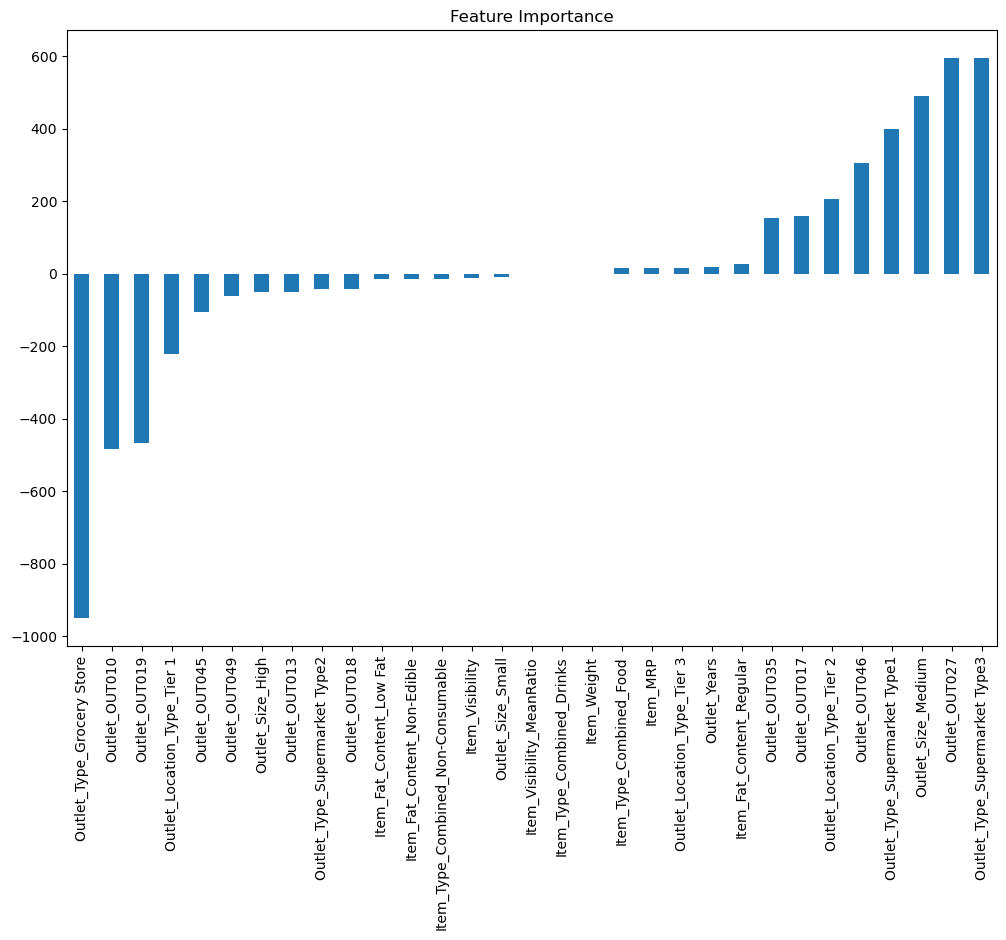

In [506]:
coef1.plot.bar(title='Feature Importance');

If you notice the coefficients, they are very large in magnitude which signifies overfitting.

In [498]:
alg_linreg2 = LinearRegression()
modelfitscaling(alg_linreg2, train, test)

,RMSE,Cross Validated RMSE
Original,1127,1130
Normalized,1128,1131
Standardized,1127,1130


## Ridge Regression Model

In [524]:
from sklearn.linear_model import Ridge
alg_ridreg1 = Ridge(alpha=0.05)
modelfit(alg_ridreg1, train, test, 'data/bigmart-sales-prediction/model-ridge-regression-by-function.csv')


Model Report
RMSE: 1127
CV Score: Mean - 1130 | Std - 16.62 | Min - 1108 | Max - 1163


C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\2376030391.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Item_Outlet_Sales'] = test_predictions


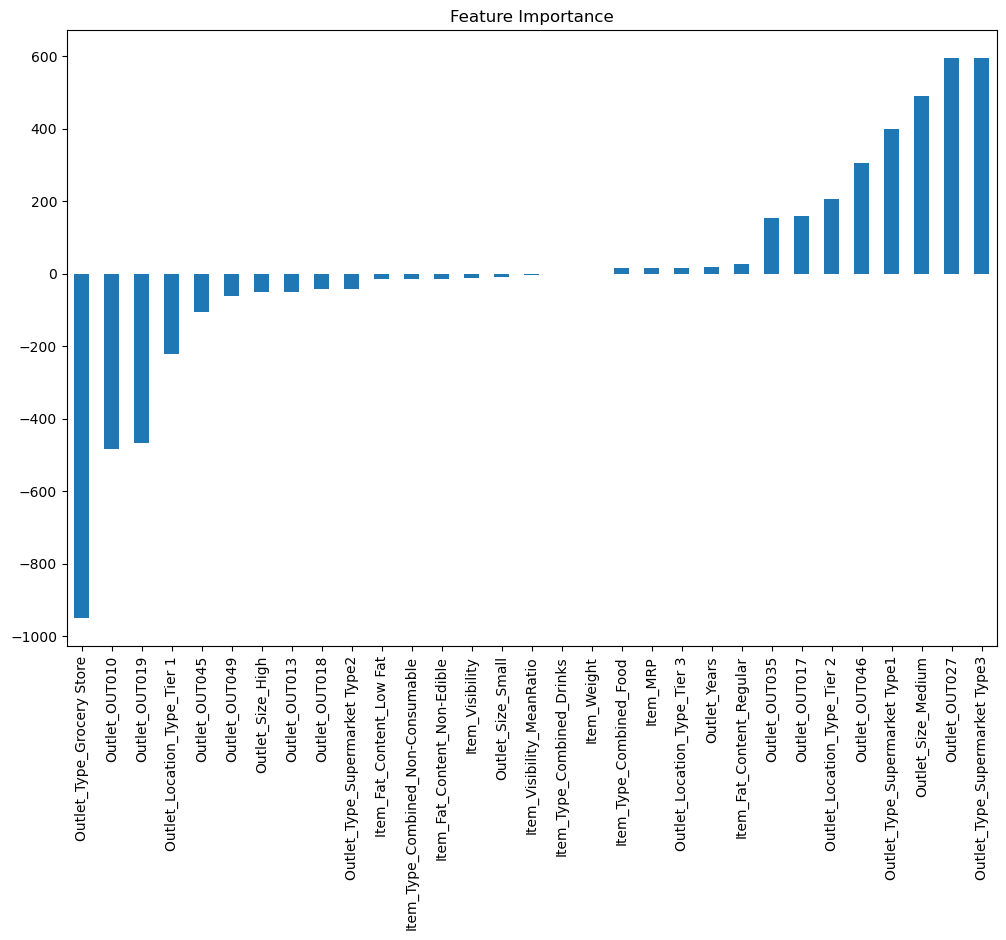

In [525]:
coef2 = pd.Series(alg_ridreg1.coef_, X_train.columns).sort_values()
coef2.plot.bar(title='Feature Importance');

Though the regression coefficient look better now, the score is about the same. You can tune the parameters of the model for slightly better results but I don’t think there will be a significant improvement. Even the cross-validation score is same so we can’t expect way better performance.

In [508]:
alg_ridreg2 = Ridge(alpha=0.05)
modelfitscaling(alg_ridreg2, train, test)

,RMSE,Cross Validated RMSE
Original,1127,1130
Normalized,1127,1130
Standardized,1127,1130


## Decision Tree Model

In [509]:
from sklearn.tree import DecisionTreeRegressor
alg_dectree1 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg_dectree1, train, test, 'data/bigmart-sales-prediction/model-decision-tree-by-function.csv')


Model Report
RMSE: 1059
CV Score: Mean - 1096 | Std - 17.01 | Min - 1075 | Max - 1129


C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\2376030391.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Item_Outlet_Sales'] = test_predictions


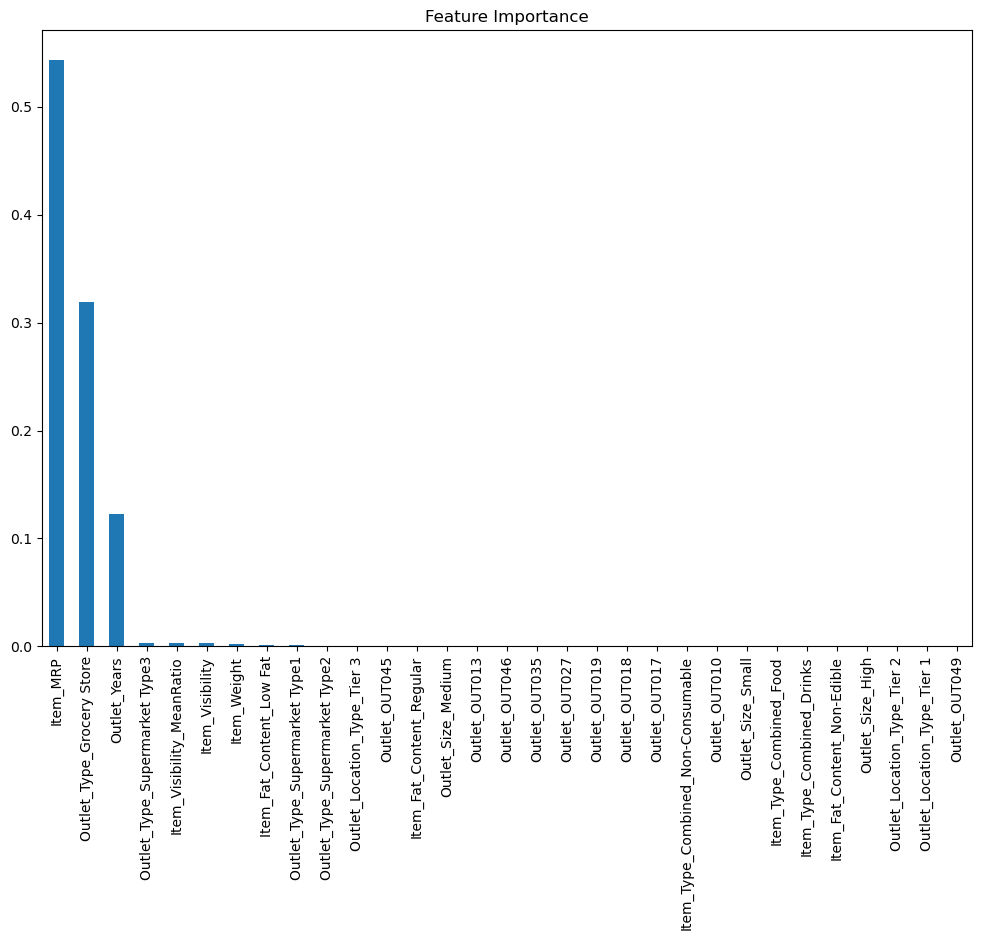

In [512]:
coef3 = pd.Series(alg_dectree1.feature_importances_, X_train.columns).sort_values(ascending=False)
coef3.plot.bar(title='Feature Importance');

Here you can see that the RMSE is 1058 and the mean CV error is 1091. This tells us that the model is slightly overfitting. Lets try making a decision tree with just top 3 variables, a max_depth of 8 and min_samples_leaf as 150.

In [533]:
alg_dectree2 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)

X_train_ = train[['Item_MRP','Outlet_Type_Grocery Store','Outlet_Years']]
y_train = train['Item_Outlet_Sales']
alg_dectree2.fit(X_train_, y_train)

train_predictions = alg_dectree2.predict(X_train_)

RMSE = np.sqrt(mean_squared_error(y_train, train_predictions))

cv_score = cross_val_score(alg_dectree2, X_train_, y_train, cv=10, scoring='neg_mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score)) #Calculates RMSE (root mean squared error)

print("\nModel Report")
print(f"RMSE1: {round(RMSE)}") #or: print("RMSE: %.4g" % RMSE)
print(f"CV Score1: Mean - {round(np.mean(cv_score))} | Std - {round(np.std(cv_score),2)} | Min - {round(np.min(cv_score))} | Max - {round(np.max(cv_score))}")
#or: print("CV Score1: Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score1),np.std(cv_score1),np.min(cv_score1),np.max(cv_score1)))


Model Report
RMSE1: 1071
CV Score1: Mean - 1094 | Std - 21.02 | Min - 1064 | Max - 1132


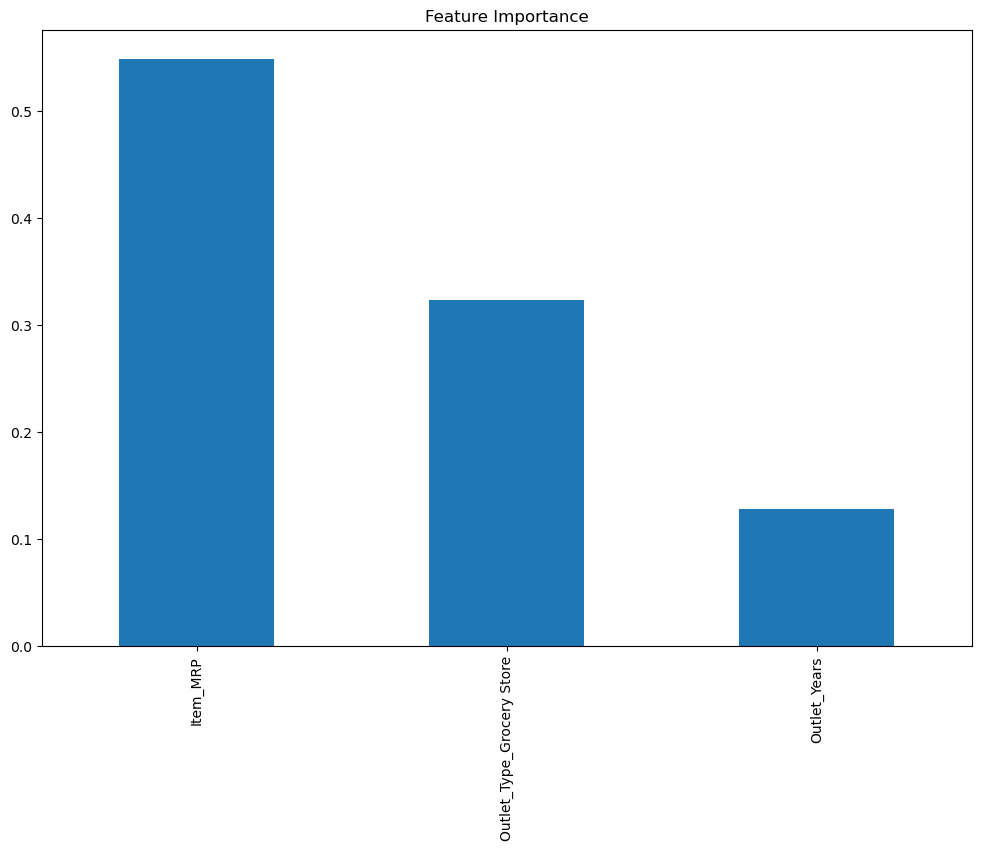

In [534]:
coef4 = pd.Series(alg_dectree2.feature_importances_, X_train.columns).sort_values(ascending=False)
coef4.plot.bar(title='Feature Importance');

In [515]:
alg_dectree3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfitscaling(alg_dectree3, train, test)

,RMSE,Cross Validated RMSE
Original,1059,1096
Normalized,1059,1096
Standardized,1059,1096


## Random Forest Model

In [516]:
from sklearn.ensemble import RandomForestRegressor
alg_ranfor1 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg_ranfor1, train, test, 'data/bigmart-sales-prediction/model-random-forest-by-function.csv')


Model Report
RMSE: 1073
CV Score: Mean - 1085 | Std - 19.76 | Min - 1051 | Max - 1113


C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\2376030391.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Item_Outlet_Sales'] = test_predictions


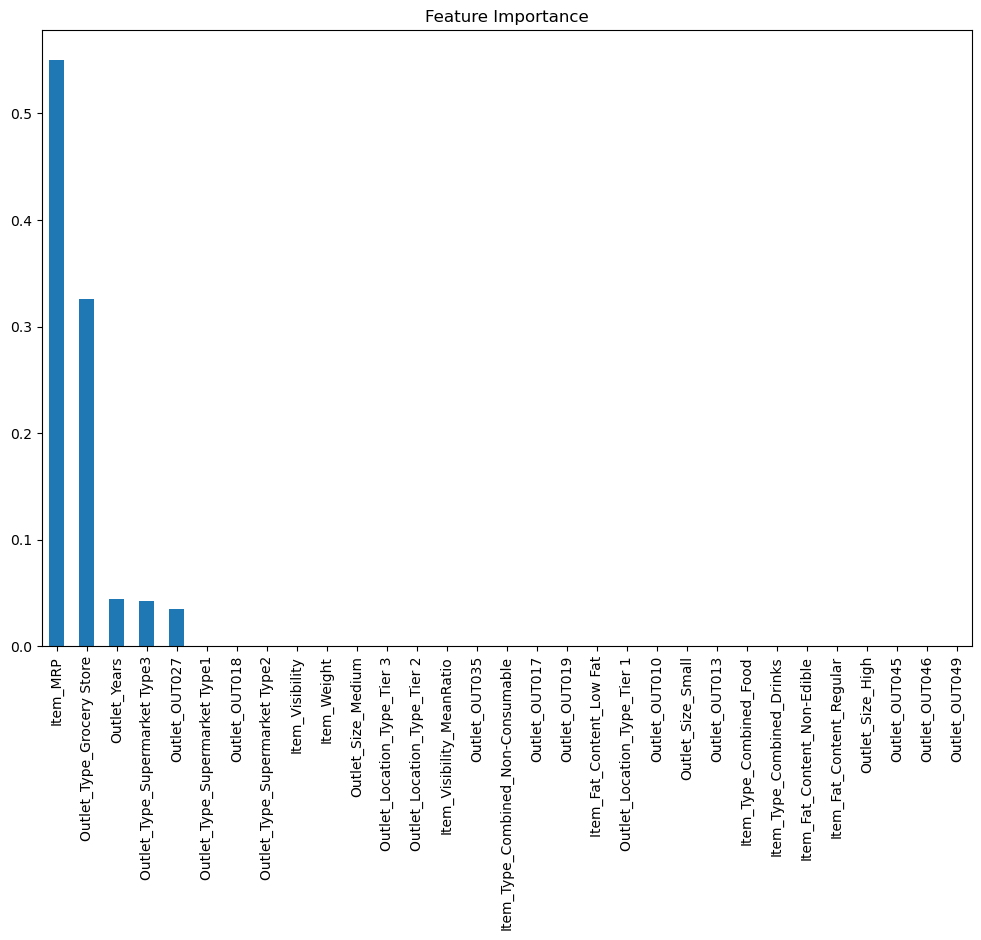

In [517]:
coef5 = pd.Series(alg_ranfor1.feature_importances_, X_train.columns).sort_values(ascending=False)
coef5.plot.bar(title='Feature Importance');

You might feel this is a very small improvement but as our model gets better, achieving even minute improvements becomes exponentially difficult. Lets try another random forest with max_depth of 6 and 400 trees. Increasing the number of trees makes the model robust but is computationally expensive.

In [518]:
alg_ranfor2 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg_ranfor2, train, test, 'data/bigmart-sales-prediction/model-random-forest-by-function2.csv')


Model Report
RMSE: 1068
CV Score: Mean - 1085 | Std - 20.22 | Min - 1050 | Max - 1113


C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\2376030391.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Item_Outlet_Sales'] = test_predictions


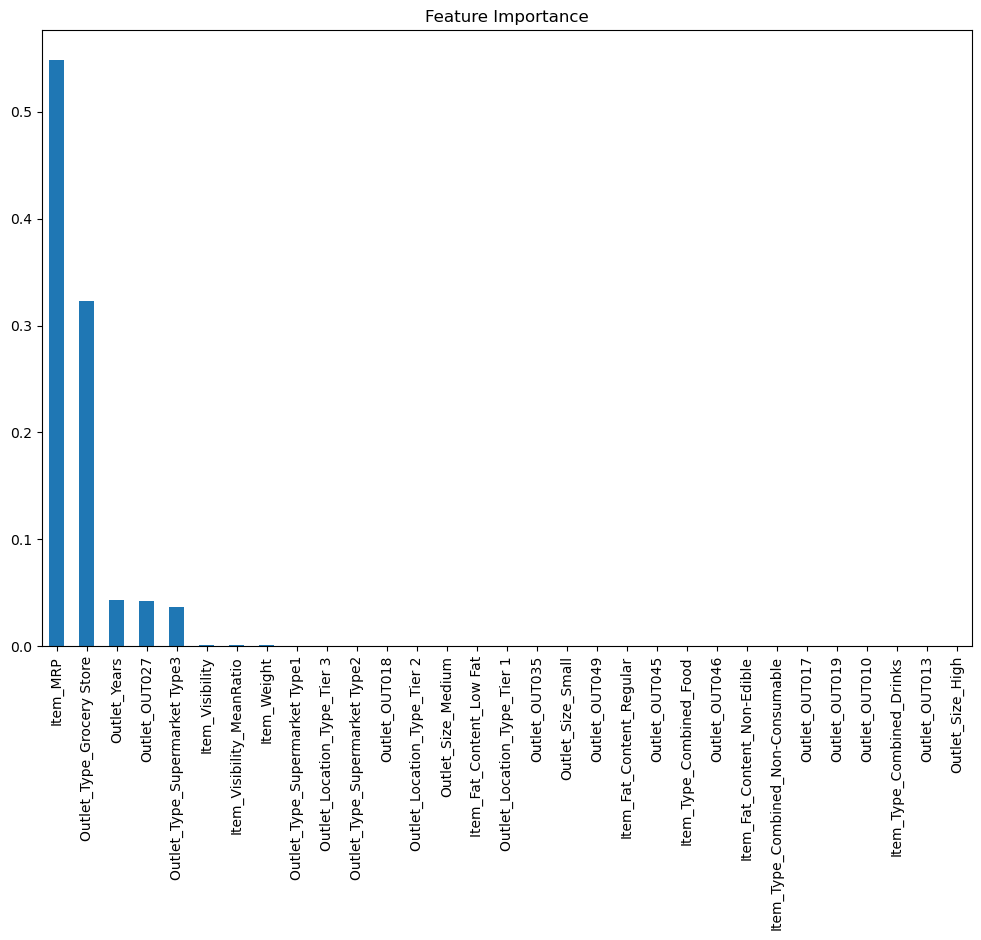

In [536]:
coef6 = pd.Series(alg_ranfor2.feature_importances_, X_train.columns).sort_values(ascending=False)
coef6.plot.bar(title='Feature Importance');

Again this is an incremental change. 

In [520]:
alg_ranfor3 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfitscaling(alg_ranfor3, train, test)

,RMSE,Cross Validated RMSE
Original,1068,1089
Normalized,1068,1089
Standardized,1068,1089


## Support Vector Regressor (SVR)
SVR is another distance-based algorithm. So let’s check out whether it works better with normalization or standardization:

In [521]:
from sklearn.svm import SVR
svr1 = SVR(kernel='rbf', C=5)
modelfit(svr1, train, test, 'data/bigmart-sales-prediction/model-SVR-by-function.csv')


Model Report
RMSE: 1425
CV Score: Mean - 1427 | Std - 39.7 | Min - 1346 | Max - 1479


C:\Users\MYPC\AppData\Local\Temp\ipykernel_7932\2376030391.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Item_Outlet_Sales'] = test_predictions


In [522]:
svr2 = SVR(kernel='rbf', C=5)
modelfitscaling(svr2, train, test)

,RMSE,Cross Validated RMSE
Original,1425,1429
Normalized,1509,1543
Standardized,1312,1353
